# Motivation
This notebook is based on Lessons 1 & 2 of the excellent course from https://course.fast.ai/

It uses the fastai library to build an image classifier for detecting cannabis edibles vs real sweets from images harvested from google.

This notebook is run on GCP with the fastai flavour of the deep learning vm from the image marketplace

In [1]:
from fastai.vision import *

# Training data
In Lesson 2 we are given the following code for downloading a a csv of the urls of a google search from the browser console.

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

So you will need to go to google and search for 

"Stoney Patch Kids"

and grab a csv of the urls of the images for each search, these can then be uploaded to the image via the jupyter UI.

This can be repeated for "Sour Patch Kids - Stoney Patch Kids"


In [2]:
DATA_FOLDER = 'data/edibles_classification'

def download_files(folder, file):
    path = Path(DATA_FOLDER)
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)

    download_images(file, dest, max_pics=200)

In [3]:
download_files("stoney_patch", "stoney_patch_urls.csv")
download_files("sour_patch", "sour_patch_urls.csv")

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

In [4]:
# You will then check that all of the images are openable and can be used in the model, this is very useful inbuilt functionality of the fastai package.
# verify_images will delete images which won't open and try and transform any which are not in RGB format

classes = ["stoney_patch", "sour_patch"]
path = Path(DATA_FOLDER)

for clazz in classes:
    verify_images(path/clazz, delete=True, max_size=500)

In [5]:
# The function ImageDataBunch.from_folder creates an object which inclues a train and validation dataset and performs various best practice data augmentation procedures (flip, rotate, `zoom`, warp, lighting transforms.")
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [6]:
??get_transforms

In [7]:
# The ongoing theme of the fastai package is to try and give you defaults which work well out of the box
# This could be considered to be dangerous as you can be lazy and not delve too deeply into the black box
# However i'm only a few lessons in and Jeremey Howard did explain the top down approach and the detail comes with more and more complicated problems

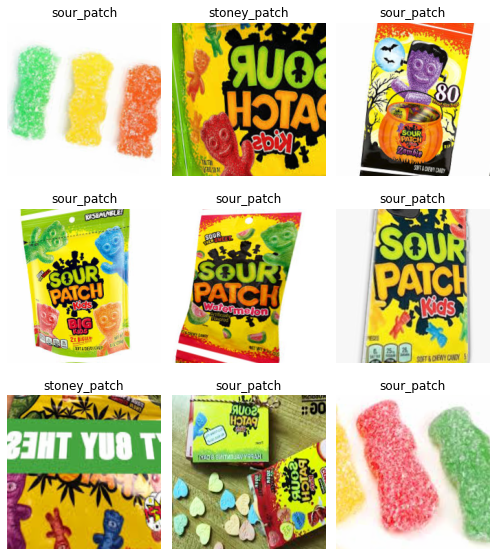

In [8]:
# All of the helper functions make the interrogation of the data alot easier, They really make identifying any data problems  alot easier
data.show_batch(rows=3, figsize=(7,8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['sour_patch', 'stoney_patch'], 2, 258, 64)

In [10]:
# I had problems with different data sets giving a lot of trash urls and had very unevenly distributed data, i work with highly skewed data sets alot and am very wary of it. 
# Interestingly Jeremy claims he's never had a problem with poor models from imbalanced datasets which surprised me
pd.value_counts(data.train_ds.y.items, sort=False)

0    129
1    129
dtype: int64

# Modelling
Now to the fun bit, fastai provides a CNNLearner object which combines a Deep CNN based architecture for feature extraction and a fully connected classfication head. There are lots of options in the "fastai model zoo" for prebuilt model architechtures you can use with the cnn_learner

In [11]:
# We create the model based off a resnet 34 architecture
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [12]:
??cnn_learner

In [13]:
# Train the model with only the classification layers able to update ( the CNN blocks are frozen so they don't catastrophically unlearn at this point)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.169098,1.908519,0.468750,00:02
1,0.876620,3.467976,0.500000,00:01
2,0.705181,2.559698,0.421875,00:01
3,0.607319,1.496974,0.296875,00:01


In [14]:
# The fit_one_cycle uses the idea created by Leslie Smith on varying Learning rates for training Neural Networks to converge optimally and quickly
# an excellent explanation is available at https://sgugger.github.io/the-1cycle-policy.html

In [15]:
# Save the weights for the model where only the classification head has been trained
learn.save('stage-1')

In [ ]:
# We can now fine tune the weights in the resnet40 architecture
# We want to find the appropriate lower bound for the LR in the 1-cycle policy, for this we will use the learning rate finder with all layers in the model trainable

learn.load("stage-1")
learn.unfreeze()
learn.lr_find(start_lr=1e-6, end_lr=1e-2)
learn.recorder.plot()

In [ ]:
# When choosing the maximum learning rate we're looking for a point 
#where the loss is decreasing sharply relatively near the minimum loss 

# 3e-4 looks like a good max rate

learn.load("stage-1")
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-5,8e-4))

In [ ]:
# I have trained this for a unneccesary of epochs just to highlight how quickly we converged to an optimal values (2 epochs), beyond this the validation error_rate did not improve.

learn.save('stage-2')

# Model interpretation

Aswell as the standard methods such as a confusion matrix we can take advantage of other fastai functionality to identify the misclassified examples

In [ ]:
learn.load('stage-2');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
# These are pretty good results but let's dig into the data and see if there are any ambiguous images which are messing up the classifier

# We need to create a dataset without the train/validation split 
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

# Load the model with this new dataset
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [ ]:
from fastai.widgets import *
# Identify the images the model is struggling to classify as they are returning the largest losses
ds, idxs = DatasetFormatter().from_toplosses(learn_cln) 

In [ ]:
# This little widget displays the images so we can delete any incorrect or badly labelled images
# The deleted 
ImageCleaner(ds, idxs, path)

# Retrain the model with the cleaned dataset

In [ ]:
# Use the cleaned dataset to rebuild the model and see if the results improve

# The information for the deleted images is saved in data/edible_classification/cleaned.csv

cleaned_data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn_cln = cnn_learner(cleaned_data, models.resnet34, metrics=error_rate)

In [ ]:
# Train the classification head again
learn_cln.fit_one_cycle(4)

In [ ]:
# save the weights for this trained classification head
learn_cln.save('cleaned-stage-1')

In [ ]:
# We want to find the appropriate lower bound for the LR in the 1-cycle policy, for this we will use the learning rate finder with all layers in the model trainable

learn_cln.load("cleaned-stage-1")
learn_cln.unfreeze()
learn_cln.lr_find(start_lr=1e-6, end_lr=1e-2)
learn_cln.recorder.plot()

In [ ]:
# When choosing the maximum learning rate we're looking for a point 
# where the loss is decreasing sharply relatively near the minimum loss 

# 3e-4 looks like a good max rate

learn_cln.load("cleaned-stage-1")
learn_cln.unfreeze()
learn_cln.fit_one_cycle(6, max_lr=slice(1e-5,8e-4))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_cln)

In [ ]:
interp.plot_confusion_matrix()